In [152]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [153]:
file_path = "cleaned_dataset.csv"  # Укажите путь к вашему CSV-файлу
df = pd.read_csv(file_path, na_values=[''])

In [154]:
def cumulative_technologies(group):
    cumulative = set()  # Используем множество для хранения уникальных технологий
    result = []
    tech_years = {}  # Словарь для хранения года внедрения каждой технологии

    for year, tech in group.items():  # Используем .items() вместо .iteritems()
        if tech:  # Игнорируем пустые строки
            # Разделяем строку на отдельные технологии по запятым
            technologies = [t.strip() for t in tech.split(',')]
            for t in technologies:
                tech_years[t] = year  # Запоминаем год внедрения технологии
                cumulative.add(t)

        # Удаляем технологии, срок действия которых истек (более 3 лет назад)
        current_year = year
        cumulative = {t for t in cumulative if current_year - tech_years[t] <= 3}

        # Объединяем уникальные технологии в строку с разделителем запятая
        result.append(', '.join(sorted(cumulative)))  # Сортируем для удобства

    return result

In [155]:
print(df.reset_index().groupby('Компания')['size_cat'].nunique().value_counts())


size_cat
1    526
2     42
Name: count, dtype: int64


In [156]:
# Заполняем пропущенные значения в столбце 'Технология' пустой строкой
df['Технология'] = df['Технология'].fillna('')

# Сортируем данные по компании и году
df = df.sort_values(by=['Компания', 'year'])

# Применяем функцию к каждой группе
df['Кумулятивные_технологии'] = df.groupby('Компания')['Технология'].transform(cumulative_technologies)

In [157]:
df['techdm'] = df['Кумулятивные_технологии'].apply(lambda x: 1 if x else 0)

In [158]:
# Calculate the foundation year for each company
df['Год_основания'] = df.groupby('Компания')['year'].transform('min')

# Calculate the age of the company
df['age'] = df['year'] - df['Год_основания']

---
Строю регрессию тут

In [159]:
# Преобразование строки технологий в список и подсчет количества
df['Количество_технологий'] = df['Кумулятивные_технологии'].apply(
    lambda x: len(set(x.split(', '))) if x else 0
)

In [160]:
df = df.groupby(['Компания', 'year']).first()

In [161]:
# Создаем дамми-переменные для столбца 'ind'
ind_dummies = pd.get_dummies(df['ind'], prefix='Industry', drop_first=True).set_index(df.index)
size_dummies = pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True).set_index(df.index)

# Присоединяем дамми-переменные к основному датафрейму
df = pd.concat([df, ind_dummies], axis=1)
df = pd.concat([df, size_dummies], axis=1)

In [162]:
print("ind_dummies duplicated indices:", ind_dummies.index.duplicated().sum())
print("size_dummies duplicated indices:", size_dummies.index.duplicated().sum())


ind_dummies duplicated indices: 0
size_dummies duplicated indices: 0


In [163]:
print("Уникальные индексы в df:", df.index.is_unique)


Уникальные индексы в df: True


In [164]:
df.columns

Index(['Город', 'name', 'region.y', 'industry', 'size_cat', 'employees',
       'income', 'expenses', 'inventory', 'receivables', 'assets', 'passive',
       'nwc', 'equity', 'total_debt', 'sales', 'cgs', 'commercial', 'ebt',
       'eat', 'ebit', 'labor_costs', 'net_profit_margin', 'ros', 'code_okved',
       'firts_number_okved', 'ind', 'Продукт', 'Технология',
       'Кумулятивные_технологии', 'techdm', 'Год_основания', 'age',
       'Количество_технологий', 'Industry_elektrotehnika',
       'Industry_energetika', 'Industry_farmacevtika',
       'Industry_finansovye_uslugi', 'Industry_gazovaya_promyshlennost',
       'Industry_gosudarstvennye_struktury',
       'Industry_himicheskaya_promyshlennost',
       'Industry_industriya_razvlecheniy',
       'Industry_informacionnaya_bezopasnost',
       'Industry_informacionnye_tehnologii', 'Industry_internet_servisy',
       'Industry_konsalting', 'Industry_legkaya_promyshlennost',
       'Industry_lesnoe_hozyaystvo', 'Industry_logistika',

In [165]:
df['log_sales'] = np.log1p(df['sales'])
df['log_cgs'] = np.log1p(df['cgs'])
df['log_eat'] = np.log1p(df['eat'])
df['log_ebit'] = np.log1p(df['ebit'])
df['log_ebt'] = np.log1p(df['ebt'])
df['log_td'] = np.log1p(df['total_debt'])
df['log_lc'] = np.log1p(df['labor_costs'])
df['log_nwc'] = np.log1p(df['nwc'])
df['log_assets'] = np.log1p(df['assets'])
df['log_inv'] = np.log1p(df['inventory'])
df['log_eq'] = np.log1p(df['equity'])
df['log_rec'] = np.log1p(df['receivables'])
df['lag_tech'] = df.groupby(level='Компания')['Количество_технологий'].shift(1)

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home

In [166]:
df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')
df['log_empl'] = np.log1p(df['employees'])


/tmp/ipykernel_244967/107979903.py:1: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')
/tmp/ipykernel_244967/107979903.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')


In [167]:
list(df.columns)

['Город',
 'name',
 'region.y',
 'industry',
 'size_cat',
 'employees',
 'income',
 'expenses',
 'inventory',
 'receivables',
 'assets',
 'passive',
 'nwc',
 'equity',
 'total_debt',
 'sales',
 'cgs',
 'commercial',
 'ebt',
 'eat',
 'ebit',
 'labor_costs',
 'net_profit_margin',
 'ros',
 'code_okved',
 'firts_number_okved',
 'ind',
 'Продукт',
 'Технология',
 'Кумулятивные_технологии',
 'techdm',
 'Год_основания',
 'age',
 'Количество_технологий',
 'Industry_elektrotehnika',
 'Industry_energetika',
 'Industry_farmacevtika',
 'Industry_finansovye_uslugi',
 'Industry_gazovaya_promyshlennost',
 'Industry_gosudarstvennye_struktury',
 'Industry_himicheskaya_promyshlennost',
 'Industry_industriya_razvlecheniy',
 'Industry_informacionnaya_bezopasnost',
 'Industry_informacionnye_tehnologii',
 'Industry_internet_servisy',
 'Industry_konsalting',
 'Industry_legkaya_promyshlennost',
 'Industry_lesnoe_hozyaystvo',
 'Industry_logistika',
 'Industry_mashinostroenie',
 'Industry_metallurgicheskaya_pro

In [168]:
# X — матрица предикторов без категориальных переменных
X_numerical = df[['Количество_технологий', 'assets',
 'passive',
 'nwc',
 'equity',
 'total_debt',
 'sales',
 'cgs',
 'commercial',
 'eat',
 'ebit',
 'labor_costs',
 'net_profit_margin',
 'ros',]]

# Добавляем константу для корректности расчетов
X_numerical = sm.add_constant(X_numerical)
X_numerical = X_numerical.dropna()

# Рассчитываем VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

print(vif_data)


                  Feature       VIF
0                   const      3.40
1   Количество_технологий      1.02
2                  assets 568147.23
3                 passive 568313.63
4                     nwc      1.97
5                  equity     69.07
6              total_debt     76.17
7                   sales     42.24
8                     cgs     30.81
9              commercial      2.86
10                    eat      2.21
11                   ebit      2.62
12            labor_costs      1.48
13      net_profit_margin      2.38
14                    ros      1.38


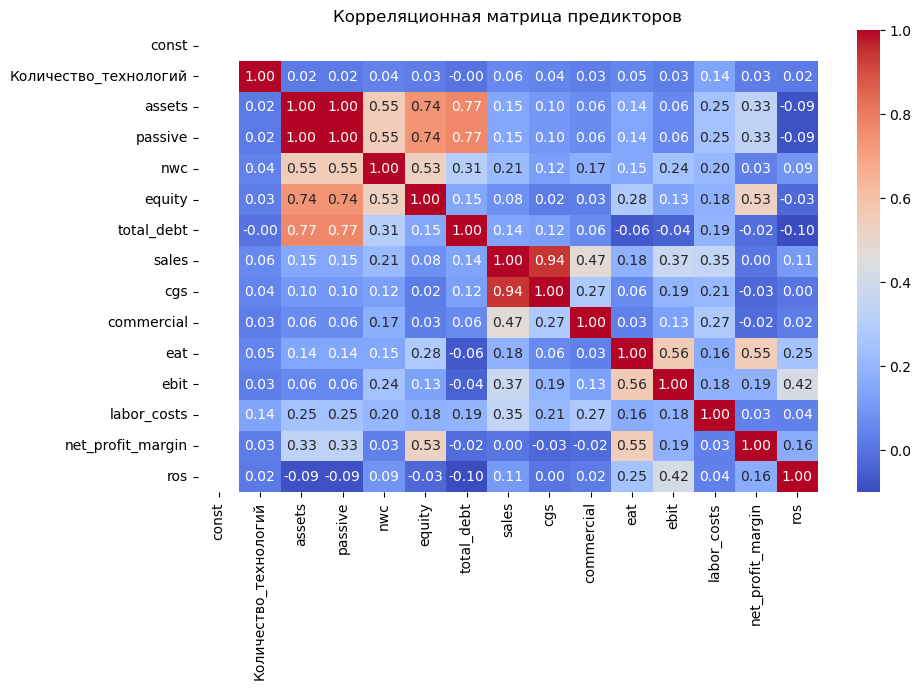

In [169]:
import seaborn as sns

corr_matrix = X_numerical.corr()

# Визуализация
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица предикторов")
plt.show()


In [170]:
# Проверка пропущенных значений в y
print(f"Пропущенные значения в y: {y.isnull().sum()}")

# Проверка пропущенных значений в X
print(f"Пропущенные значения в X: {X.isnull().sum()}")

Пропущенные значения в y: 0
Пропущенные значения в X: Количество_технологий         0
Size_Средние предприятия      0
log_eq                      340
dtype: int64


In [171]:
df.columns

Index(['Город', 'name', 'region.y', 'industry', 'size_cat', 'employees',
       'income', 'expenses', 'inventory', 'receivables', 'assets', 'passive',
       'nwc', 'equity', 'total_debt', 'sales', 'cgs', 'commercial', 'ebt',
       'eat', 'ebit', 'labor_costs', 'net_profit_margin', 'ros', 'code_okved',
       'firts_number_okved', 'ind', 'Продукт', 'Технология',
       'Кумулятивные_технологии', 'techdm', 'Год_основания', 'age',
       'Количество_технологий', 'Industry_elektrotehnika',
       'Industry_energetika', 'Industry_farmacevtika',
       'Industry_finansovye_uslugi', 'Industry_gazovaya_promyshlennost',
       'Industry_gosudarstvennye_struktury',
       'Industry_himicheskaya_promyshlennost',
       'Industry_industriya_razvlecheniy',
       'Industry_informacionnaya_bezopasnost',
       'Industry_informacionnye_tehnologii', 'Industry_internet_servisy',
       'Industry_konsalting', 'Industry_legkaya_promyshlennost',
       'Industry_lesnoe_hozyaystvo', 'Industry_logistika',

In [172]:
# Зависимая переменная
y = df['log_sales']
X = df[['Количество_технологий']]
X = X.join(size_dummies)

financial_controls = ['log_empl']
X = X.join(df[financial_controls])


In [173]:
# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_sales   R-squared:                        0.2415
Estimator:                   PanelOLS   R-squared (Between):              0.4239
No. Observations:                4104   R-squared (Within):               0.2717
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.4290
Time:                        13:27:06   Log-likelihood                   -2912.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      375.33
Entities:                         555   P-value                           0.0000
Avg Obs:                       7.3946   Distribution:                  F(3,3536)
Min Obs:                       4.0000                                           
Max Obs:                       11.000   F-statistic (robust):             71.902
                            

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [174]:
y = df['log_ebt']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_assets']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                log_ebt   R-squared:                        0.1098
Estimator:                   PanelOLS   R-squared (Between):              0.9769
No. Observations:                3630   R-squared (Within):               0.1851
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.9668
Time:                        13:27:06   Log-likelihood                   -5193.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      125.74
Entities:                         560   P-value                           0.0000
Avg Obs:                       6.4821   Distribution:                  F(3,3057)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             47.585
                            

In [175]:
y = df['log_cgs']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_inv']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                log_cgs   R-squared:                        0.0747
Estimator:                   PanelOLS   R-squared (Between):              0.2531
No. Observations:                4106   R-squared (Within):               0.1120
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.2557
Time:                        13:27:07   Log-likelihood                   -3646.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      95.055
Entities:                         562   P-value                           0.0000
Avg Obs:                       7.3060   Distribution:                  F(3,3531)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             23.666
                            

In [176]:
y = df['log_ebt']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_eq']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                log_ebt   R-squared:                        0.2034
Estimator:                   PanelOLS   R-squared (Between):              0.9713
No. Observations:                3518   R-squared (Within):               0.2746
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.9662
Time:                        13:27:07   Log-likelihood                   -4790.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      251.62
Entities:                         548   P-value                           0.0000
Avg Obs:                       6.4197   Distribution:                  F(3,2957)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             70.948
                            

In [177]:
y = df['log_ebt']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_sales']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                log_ebt   R-squared:                        0.2299
Estimator:                   PanelOLS   R-squared (Between):              0.6950
No. Observations:                3630   R-squared (Within):               0.2957
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.6849
Time:                        13:27:07   Log-likelihood                   -4930.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      304.24
Entities:                         560   P-value                           0.0000
Avg Obs:                       6.4821   Distribution:                  F(3,3057)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             131.11
                            

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [178]:
y = df['log_sales']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_assets']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:              log_sales   R-squared:                        0.3149
Estimator:                   PanelOLS   R-squared (Between):              0.8997
No. Observations:                4216   R-squared (Within):               0.4257
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.8999
Time:                        13:27:07   Log-likelihood                   -2731.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      556.95
Entities:                         568   P-value                           0.0000
Avg Obs:                       7.4225   Distribution:                  F(3,3635)
Min Obs:                       4.0000                                           
Max Obs:                       11.000   F-statistic (robust):             96.546
                            

In [179]:
y = df['log_sales']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_rec']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:              log_sales   R-squared:                        0.2639
Estimator:                   PanelOLS   R-squared (Between):              0.6385
No. Observations:                4212   R-squared (Within):               0.3371
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.6381
Time:                        13:27:07   Log-likelihood                   -2879.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      433.86
Entities:                         568   P-value                           0.0000
Avg Obs:                       7.4155   Distribution:                  F(3,3631)
Min Obs:                       4.0000                                           
Max Obs:                       11.000   F-statistic (robust):             63.790
                            

In [180]:
y = df['log_td']
X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
financial_controls = ['log_eq']
X = X.join(df[financial_controls])

# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 log_td   R-squared:                        0.0330
Estimator:                   PanelOLS   R-squared (Between):              0.2451
No. Observations:                3877   R-squared (Within):               0.0867
Date:                Fri, Mar 21 2025   R-squared (Overall):              0.2465
Time:                        13:27:07   Log-likelihood                   -3333.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      37.670
Entities:                         553   P-value                           0.0000
Avg Obs:                       7.0108   Distribution:                  F(3,3311)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             10.958
                            

In [181]:
from linearmodels.panel import RandomEffects
from scipy.stats import chi2

In [182]:
fe_model = PanelOLS(y, X, entity_effects=True).fit()

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [183]:
re_model = RandomEffects(y, X).fit()

/home/pavel/miniconda3/envs/jupiter/lib/python3.12/site-packages/linearmodels/panel/model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [184]:
b_fe = fe_model.params
b_re = re_model.params
diff = b_fe - b_re

In [185]:
V_fe = fe_model.cov
V_re = re_model.cov
V_diff = V_fe - V_re

In [186]:
chi2_stat = diff.T @ np.linalg.inv(V_diff) @ diff
p_value = 1 - chi2.cdf(chi2_stat, df=len(diff))

In [187]:
print(f'Hausman test statistic: {chi2_stat:.4f}')
print(f'P-value: {p_value:.4f}')

Hausman test statistic: 4195.3739
P-value: 0.0000
